In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib notebook

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.svm import SVC
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# PCA-zoo

This notebook explores different methods for calculating Principle Component Analysis and some clever usecases in neural networks.  
https://arxiv.org/abs/1404.3606 PCAnet  
https://arxiv.org/abs/1512.06337 kernel-PCAnet*  
  
*Unfortunately my laptop has limited amount of RAM and I can't test kPCAnet....  
  
  
Dimensionality of extracted features is usually much larger than in original features, so first guess was using SVMs to classify afterwards.  
Some people seem to use RandomForests or similar but especially with kPCAnet the number of features tends to be very high. I'm not sure  
whether I missed something, since other implementations have way lower number of features. But then this is controlled by filtersize, stride,  
and number of blocks used for hashing. Latter is mostly influenced by the number of filters of in the second stage, since the histogram size  
is '2 ^ (filters in 2nd stage)'.  
  
The total number of extracted features is **( 2^[#stage2 filters] \* [#stage1 filters] \* [#blocks] )**


## Power iteration PCA  
calculates PCA via power iteration and deflation  
pros:  
- only a single hyperparam, that has to be just high enough
  
cons:  
- computes PCs iteratively, so only use it if you want to know the first few

In [2]:
def power_pca(data, number_of_components = 8,iterations=100,M=[]):
    '''
    input: data, or M = data x data     ( ASSUMPTION:  data.mean(0) = ZERO !!)
    output: first 'number_of_components' of eigenvalues and eigenvectors
    '''
    if np.array(M).shape[0] > 0: pass # do better checking 
    else: M = np.dot(data.T,data)
    
    eigenwerte = []
    eigenvektoren = []
    for k in range(number_of_components):
        ev_zero = np.random.uniform(-1,1,(M.shape[0]))
        ev_zero /= np.linalg.norm(ev_zero)
        eV = ev_zero
        for i in range(iterations):
            eV = np.dot(M,eV)
            eW = np.linalg.norm(eV)
            eV = eV / eW
        eigenwerte  += [eW]
        eigenvektoren += [eV]
        M = M - eW*np.dot(eV[:,True],eV[:,True].T)
        
    return np.array(eigenwerte), np.array(eigenvektoren)


## GHA (Hebbian PCA)  
the general hebbian algorithm ...calculates PCA via Sanger's rule / Oja's rule & Gram-Schmidt orthonormalization  
pros:  
- kinda fast  
- online PCA
  
cons:  
- the usual learningrate-hyperparam stuff ...make it small enough or loose accuracy blabla

In [3]:
def hebbian_pca(data, number_of_components =8, w =[], lr =0.001, iterations =100):
    '''
    input: data (N x d)        ( ASSUMPTION:  data.mean(0) = ZERO !!)
    output: first 'number_of_components' of eigenvectors 'w'
    
    '''
    npc = number_of_components
    if np.array(w).shape[0] > 0: pass # do better checking 
    else: w = np.random.uniform(-1,1,(data.shape[1],npc))

    for iters in range(iterations):
        for x in data:
            y = np.dot(w.T,x[:,True])
            Ymat= []
            for i in range(npc):
                Ymat += [y]
            Y_mat = np.array(Ymat)[:,:,0]
            tril_mat = np.tril(Y_mat,k=0).T
            S_mat = np.dot(w,tril_mat)
            Xmat= []
            for i in range(npc):
                Xmat += [x]
            X_mat = np.array(Xmat).T
            dw = lr * y[:,0]* (X_mat - S_mat)
            w += dw
    return w


### PCA showdown  
comparing power PCA with GHA and eigendecomposition  by plotting PC1 vs PC2  
(notice how signs are flipped sometimes)

done with donald hebb
done with power
done with numpy


<IPython.core.display.Javascript object>


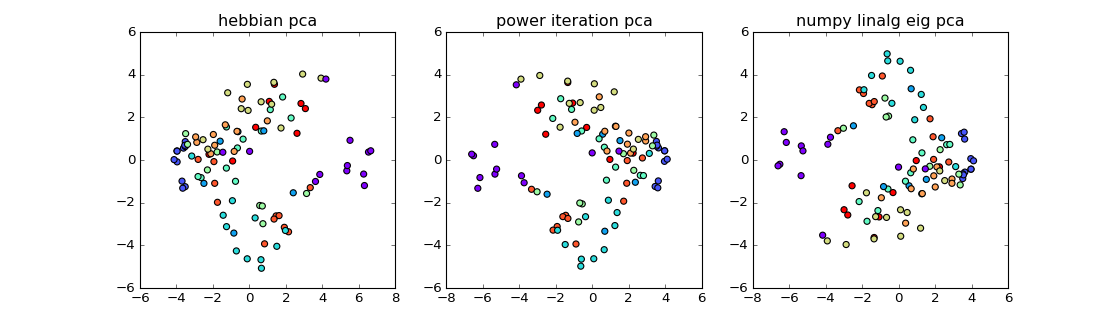

C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
data = mnist.train.images[:100]
data -= data.mean(0)

w = hebbian_pca(data,number_of_components= 10)
print('done with donald hebb')
ew, ev = power_pca(data[:100],number_of_components=10)
print('done with power')
eW, eV = np.linalg.eig(np.dot(data[:100].T,data[:100]))
print('done with numpy')
reco_A = np.dot(data[:100],w)
reco_B = np.dot(data[:100],ev.T)
reco_C = np.dot(data[:100],eV)


plt.figure(figsize=(14,4))
colors = np.argmax(mnist.train.labels[:100],axis=1)/10. +.1
plt.subplot(131)
plt.scatter(reco_A[:,0],reco_A[:,1],c=colors,edgecolors=None,s=30,cmap='rainbow')
plt.title('hebbian pca')
plt.subplot(132)
plt.scatter(reco_B[:,0],reco_B[:,1],c=colors,edgecolors=None,s=30,cmap='rainbow')
plt.title('power iteration pca')
plt.subplot(133)
plt.scatter(reco_C[:,0],reco_C[:,1],c=colors,edgecolors=None,s=30,cmap='rainbow')
plt.title('numpy linalg eig pca')
plt.show()


## kernelPCA  
kernelPCA function with different kernels and a projection function for new data  
pros:  
- kernel stuff, the usual magic
  
cons:  
- lots of data = huuuuge kernel matrices ....better have a sh*tload of RAM available  
- have I mentioned hyperparameters you can tune?

In [14]:
#kernels:
def rbf_K(x,y,gamma=0.1):
    return np.exp(- gamma*(np.linalg.norm(x-y))**2 )

def lin_K(x, y, c=0.):
    return np.dot(x, y) + c

def poly_K(x, y, p=3):
    return np.power((1 + np.dot(x, y)),p)


def kernel_pca(data,kernel=rbf_K,number_of_components=8):
    '''
    kernel PCA using power method to calculate components
    
    input: data  (doesn't have to be centered, since PCA is performed in Kernel-space and Kernel is centered)
    output: first 'number_of_components' of eigenvalues and eigenvectors
    
    '''
    K_data = np.empty((data.shape[0],data.shape[0]))
    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            K_data[i,j] = kernel(data[i],data[j])
       
    K_data_mean_zero = K_data.mean(0)
    K_data_mean_one = K_data.mean(1)
    K_data_mean = K_data.mean()
    K_data_centered = K_data - K_data_mean_zero - K_data_mean_one + K_data_mean
    
    eW , eV = power_pca(K_data , M=K_data_centered,number_of_components=number_of_components,iterations=100)
    
    return eW, eV


def kpca_proj(new_data, pca_data, eV, eW, kernel= rbf_K):
    new_data_kernel = np.empty((new_data.shape[0],pca_data.shape[0]))
    for i in range(new_data.shape[0]):
        for j in range(pca_data.shape[0]):
            new_data_kernel[i,j] = kernel(new_data[i],pca_data[j])
        
    return new_data_kernel.dot(eV.T / eW)


### kernel showdown  
kernelPCA is super cool, but notice the importance of hyperparameter choice.

<IPython.core.display.Javascript object>


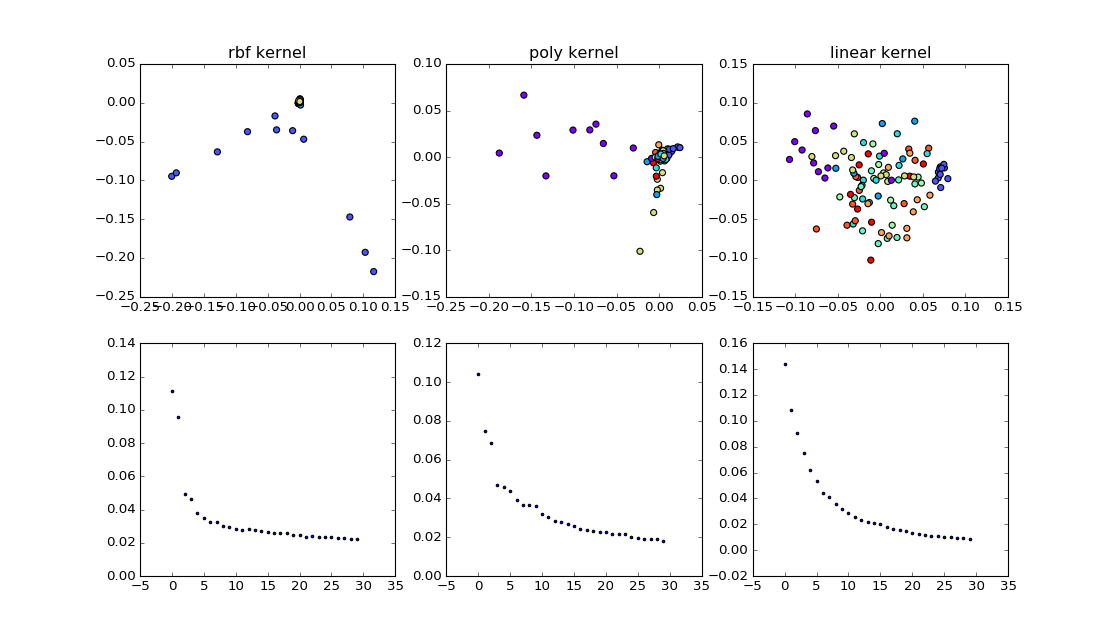

In [15]:
data = mnist.train.images[500:1000]
data -= data.mean(0)
newdata = mnist.train.images[:100]
#rbf
eWa, eVa = kernel_pca(data,rbf_K,30)
projection_rbf = kpca_proj(newdata, data, eVa, eWa, kernel= rbf_K)
#poly
eWb, eVb = kernel_pca(data,poly_K,30)
projection_poly = kpca_proj(newdata, data, eVb, eWb, kernel= poly_K)
#linear
eWc, eVc = kernel_pca(data,lin_K,30)
projection_lin = kpca_proj(newdata, data, eVc, eWc, kernel= lin_K)

plt.figure(figsize=(14,8))
colors = np.argmax(mnist.train.labels[:100],axis=1)/10. +.1
#rbf
plt.subplot(231)
plt.scatter(projection_rbf[:,0],projection_rbf[:,1],c=colors,edgecolors=None,s=30,cmap='rainbow')
plt.title('rbf kernel')
plt.subplot(234)
plt.scatter(range(eWa.shape[0]),eWa/np.sum(eWa),s=5)

#poly
plt.subplot(232)
plt.scatter(projection_poly[:,0],projection_poly[:,1],c=colors,edgecolors=None,s=30,cmap='rainbow')
plt.title('poly kernel')
plt.subplot(235)
plt.scatter(range(eWb.shape[0]),eWb/np.sum(eWb),s=5)

#lin
plt.subplot(233)
plt.scatter(projection_lin[:,0],projection_lin[:,1],c=colors,edgecolors=None,s=30,cmap='rainbow')
plt.title('linear kernel')
plt.subplot(236)
plt.scatter(range(eWc.shape[0]),eWc/np.sum(eWc),s=5)

plt.show()


# PCAnet

In [7]:
def make_patches(inputs, filter_size=7 ,stride=1 ):
    '''
    input: N x W x H images
    output: creates patches with zero-mean 
    
    '''
    if len(inputs.shape) > 3:
        inputs = inputs.reshape(inputs.shape[0]*inputs.shape[1],inputs.shape[2],inputs.shape[3])
    X = []
    for img in range(inputs.shape[0]): 
        arr = inputs[img]
        sub_arr = []
        x = y = 0
        while (x+filter_size) <= arr.shape[0]:
            y = 0
            while (y+filter_size) <= arr.shape[1]:
                sub_arr += [arr[x:x+filter_size,y:y+filter_size]]
                y += stride
            x += stride  
        sub_arr = np.array(sub_arr)
        sub_arr = sub_arr.reshape(int(np.sqrt(sub_arr.shape[0])),int(np.sqrt(sub_arr.shape[0])),(sub_arr.shape[1]),(sub_arr.shape[2]))
        sub_arrR = sub_arr.reshape(sub_arr.shape[0]**2,filter_size**2)
        sub_arrRmean = sub_arrR - sub_arrR.mean(0)
        X += [sub_arrRmean]
    X = np.array(X)
    X = X.reshape(X.shape[0]*X.shape[1],X.shape[2])
    return X

def make_filter(patches, filter_= 8):
    '''
    input: N x (W*H) patches
    output: specified number of PCA filter
    '''
    X = patches
    eW, eV = power_pca(X,number_of_components= filter_,iterations=100,M=[])
    L_filter = eV.reshape(eW.shape[0],int(np.sqrt(patches.shape[1])),int(np.sqrt(patches.shape[1])))
    
    ### adaptation to kernelPCA filters...
    #EW, EV = kernel_pca(X,rbf_K,filter_)
    #EV = EV[:,:int(patches.shape[1])]
    #print('kernel eigenvectors shape:   ',EV.shape)
    #L_filter = EV.reshape(EV.shape[0],int(np.sqrt(patches.shape[1])),int(np.sqrt(patches.shape[1])))
    #print('kernel eigenfilters shape:   ',L_filter.shape)
    
    return L_filter

def convolve_(inputs, filter_ ,stage = 1,stride=1, padding=0 ):
    '''
    input: N x (S1 x) W x H images
    output: convolved images
    '''
    if stage == 2 : 
        innerloop = inputs.shape[1]
        outerloop = inputs.shape[0]
    else: 
        innerloop = inputs.shape[0]
        outerloop = 1
    
    out_stage_two = []
    filter_shape = filter_.shape[0]
    for img in range(outerloop):  
        out_stage_one = []
        for st in range(innerloop):
            if outerloop > 1: arr = inputs[img,st]
            else: arr = inputs[st]
            if padding > 0:
                arr = np.pad(arr,padding,mode='constant')
            filter_shape = filter_.shape[1]
            sub_arr = []
            x = y = 0
            while (x+filter_shape) <= arr.shape[0]:
                y = 0
                while (y+filter_shape) <= arr.shape[1]:
                    sub_arr += [arr[x:x+filter_shape,y:y+filter_shape]]
                    y += stride
                x += stride  
            sub_arr = np.array(sub_arr)
            sub_arr = sub_arr.reshape(int(np.sqrt(sub_arr.shape[0])),int(np.sqrt(sub_arr.shape[0])),(sub_arr.shape[1]),(sub_arr.shape[2]))
            stage_arr = []
            for f in range(filter_.shape[0]):
                new_arr = (sub_arr*filter_[f]).sum(axis=(2,3))
                stage_arr += [new_arr]
            out_stage_one += [stage_arr]
        out_stage_two += [out_stage_one] 
    if stage == 1 : out_stage_two = out_stage_two[0]
    return np.array(out_stage_two)


def binarize(inputs):
    '''
    0 if <= 0
    1 else
    '''
    return np.where(inputs <= 0., 0,1)


def decimalize(inputs):
    '''
    inputs: N x S1 x S2 X W x H   binarized PCAnet outputs
    output: N x S1 x W x H x 1 decimalized PCAnet outputs
    '''
    binarr = inputs.swapaxes(2,4)
    return np.packbits(binarr,axis=4)


def make_blocks(inputs,block_size = 7, stride = 3):
    '''
    inputs: N x S1 x W x H x 1  decimalized PCAnet outputs
    output: N x S1 x B x (block_size**2) 
    '''
    images = []
    for img in range(inputs.shape[0]): 
        X = []
        for ston in range(inputs.shape[1]):

            arr = inputs[img,ston]
            sub_arr = []
            x = y = 0
            while (x+block_size) <= arr.shape[0]:
                y = 0
                while (y+block_size) <= arr.shape[1]:
                    sub_arr += [arr[x:x+block_size,y:y+block_size]]
                    y += stride
                x += stride  
            sub_arr = np.array(sub_arr)
            sub_arrR = sub_arr.reshape(sub_arr.shape[0],block_size**2)
            X += [sub_arrR]
        images += [X]
    blocks = np.array(images)
    return blocks


def histogramming(inputs):
    '''
    inputs: N x S1 x B x (block_size**2) 
    output: N x (2**S2 * S1 * B) 
    '''
    in_blocks = inputs
    features = []
    for img in range(in_blocks.shape[0]): 
        TI = []
        for ston in range(in_blocks.shape[1]):
            X = []
            for block in range(in_blocks.shape[2]):
                hist = np.histogram(in_blocks[img,ston,block],255,range=(0,255))[0]
                X += [hist]
            TI += [X]
        features += [TI]
    features = np.array(features)
    features = features.reshape(features.shape[0],features.shape[1]*features.shape[2]*features.shape[3])
    return features



## training  
create filters from patches

In [8]:
### PCAnet:
number_of_images = 1500
images = mnist.train.images[:number_of_images].reshape(number_of_images,28,28)


### TRAINING
#stage 1 
patches = make_patches(images,filter_size=7,stride=4)
print(patches.shape, 'patches' )
L1filter = make_filter(patches,filter_=8) #####1
print(L1filter.shape, 'L1 filter')
outS1 = convolve_(images,L1filter,stage=1,stride=1,padding=3)
print(outS1.shape, 'out 1')
#stage 2 
patches2 = make_patches(outS1,7,4)
print(patches2.shape, 'patches2' )
L2filter = make_filter(patches2,8) ####4
print(L2filter.shape, 'L2 filter')
outS2 = convolve_(outS1,L2filter,stage=2,stride=1,padding=3)
print(outS2.shape, 'out 2')
#binary hashing
outBIN = binarize(outS2)
print(outBIN.shape, 'out bin')
outDEC = decimalize(outBIN)
print(outDEC.shape, 'out dec')
outBlocks = make_blocks(outDEC,block_size=7,stride=3)
print(outBlocks.shape, 'out blocks')
outHist = histogramming(outBlocks)
print(outHist.shape, 'out hist')



(54000, 49) patches
(8, 7, 7) L1 filter
(1500, 8, 28, 28) out 1
(432000, 49) patches2
(8, 7, 7) L2 filter
(1500, 8, 8, 28, 28) out 2
(1500, 8, 8, 28, 28) out bin
(1500, 8, 28, 28, 1) out dec
(1500, 8, 64, 49) out blocks
(1500, 130560) out hist


### classification  
SVM is used to get some results for the training error

In [9]:
inputs = outHist
vectormachine = SVC(C=8.)
vectormachine.fit(inputs, np.argmax(mnist.train.labels[:number_of_images],axis=1))
print(vectormachine.predict(inputs[:20]))
print(np.argmax(mnist.train.labels[:20],axis=1))
print([np.where(np.argmax(mnist.train.labels[:number_of_images],axis=1) != vectormachine.predict(inputs))[0].shape[0] /  number_of_images*1.], ' train error')


[7 3 4 6 1 8 1 0 9 8 0 3 1 2 7 0 2 9 6 0]
[7 3 4 6 1 8 1 0 9 8 0 3 1 2 7 0 2 9 6 0]
[0.0]  train error


## testing  
create features for new data by convolving with trained filters.  

In [10]:
### TESTING

number_of_images = 500
images = mnist.test.images[:number_of_images].reshape(number_of_images,28,28)

#stage 1 
outS1 = convolve_(images,L1filter,stage=1,stride=1,padding=3)
print(outS1.shape, 'out 1')
#stage 2 
outS2 = convolve_(outS1,L2filter,stage=2,stride=1,padding=3)
print(outS2.shape, 'out 2')
#binary hashing
outBIN = binarize(outS2)
print(outBIN.shape, 'out bin')
outDEC = decimalize(outBIN)
print(outDEC.shape, 'out dec')
outBlocks = make_blocks(outDEC,block_size=7,stride=3)
print(outBlocks.shape, 'out blocks')
outHist_test = histogramming(outBlocks)
print(outHist.shape, 'out hist')

(500, 8, 28, 28) out 1
(500, 8, 8, 28, 28) out 2
(500, 8, 8, 28, 28) out bin
(500, 8, 28, 28, 1) out dec
(500, 8, 64, 49) out blocks
(1500, 130560) out hist


### classification  
SVM trained on original features for comparison

In [ ]:
bas = SVC(C=8.)
bas.fit(mnist.train.images[:number_of_images] , np.argmax(mnist.train.labels[:number_of_images],axis=1))

In [12]:
test_err = [np.where(np.argmax(mnist.test.labels[:number_of_images],axis=1) != vectormachine.predict(outHist_test))[0].shape[0] /  number_of_images*1.]
print('error with PCAnet features: ',test_err)
bas_err = [np.where(np.argmax(mnist.test.labels[:number_of_images],axis=1) != bas.predict(mnist.test.images[:number_of_images]))[0].shape[0] /  number_of_images*1.]
print('error w/o PCAnet features: ',bas_err)

error with PCAnet features:  [0.044]
error w/o PCAnet features:  [0.136]


## conclusion  
While there is an improvement in classification performance with PCAnet features extractor, the dimensionality growth a lot. This often  
limits the choice of classifyer due to the curse of dimensionality.  
Anyway, one could see PCAnet like a CNN without pooling, where the input only growth in volume after each stage. The binary hashing creates similar translation invariance as pooling would do. Since the volume growth in PCAnet is way higher than with traditional convolutions, the approach to  
concatenate stages until the 'image resolution' is **1x1xfeatures** is unfeasable. Maybe instead of hashing the images after the second stage, a deep convolution could be applied, which would work similar to hashing - but then again computational complexity may be too large.